## Read Dataset

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict

# Read the dataset
dataset = pd.read_csv('data/kakao_data.csv')

## Summarize Speech Frequencies

In [55]:
# Summarize speech frequencies by speaker within each meeting
speech_summary = dataset.groupby(['project', 'meeting_number', 'speaker_number'])[
    'speech_frequency'].sum().reset_index()

# Calculate adjusted speech frequencies by dividing by the number of speakers in each meeting
num_speakers_per_meeting = dataset.groupby(['project', 'meeting_number'])[
    'speaker_number'].nunique().reset_index()
num_speakers_per_meeting.columns = [
    'project', 'meeting_number', 'num_speakers']
speech_summary = pd.merge(speech_summary, num_speakers_per_meeting, on=[
                          'project', 'meeting_number'])
speech_summary['adjusted_speech_frequency'] = speech_summary['speech_frequency'] / \
    speech_summary['num_speakers']

# Ensure the sum of each speaker's adjusted speech frequency is equal to total_words within one meeting
total_words_summary = dataset.groupby(['project', 'meeting_number'])[
    'total_words'].first().reset_index()
speech_summary = pd.merge(speech_summary, total_words_summary, on=[
                          'project', 'meeting_number'])

# Normalize speech frequency by duration
meeting_durations = dataset.groupby(['project', 'meeting_number'])[
    'duration'].first().reset_index()
speech_summary = pd.merge(speech_summary, meeting_durations, on=[
                          'project', 'meeting_number'])
speech_summary['normalized_speech_frequency'] = speech_summary['adjusted_speech_frequency'] / \
    speech_summary['duration']

## Summarize Interaction Counts

In [56]:
# Compute Interaction Frequencies Excluding Self-Interactions
interaction_summary = dataset[dataset['speaker_number'] != dataset['next_speaker_id']].groupby(
    ['project', 'meeting_number', 'speaker_number', 'next_speaker_id'])['count'].sum().reset_index()

# Ensure not to count the same speaker multiple times within a meeting
interaction_summary = interaction_summary.groupby(
    ['project', 'meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Normalize interaction frequencies by duration
interaction_summary = pd.merge(interaction_summary, dataset[[
                               'project', 'meeting_number', 'duration']].drop_duplicates(), on=['project', 'meeting_number'])
interaction_summary['normalized_interaction_count'] = interaction_summary['count'] / \
    interaction_summary['duration']

## Plot Comparison of Non-Normalized Total Speech Frequencies

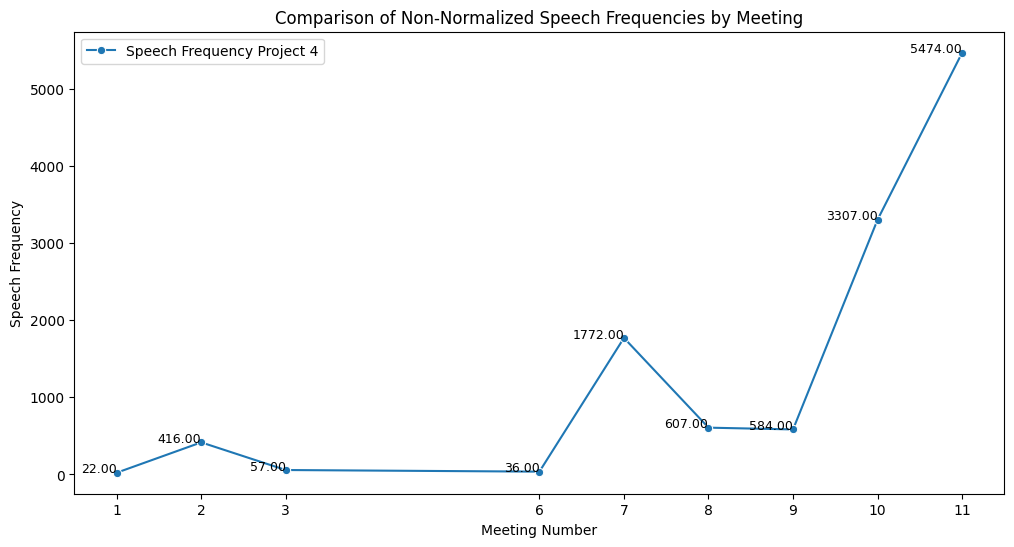

In [57]:
# Compare non-normalized speech frequencies by project
speech_comparison_df = speech_summary.groupby(['project', 'meeting_number'])[
    'adjusted_speech_frequency'].sum().reset_index()
speech_comparison_df_pivot = speech_comparison_df.pivot(
    index='meeting_number', columns='project', values='adjusted_speech_frequency')
speech_comparison_df_pivot.columns = ['Speech_Frequency_Project4']
speech_comparison_df_pivot.reset_index(inplace=True)

# Filter meeting numbers to include only those with data points for either project
meeting_numbers_with_data = speech_comparison_df_pivot[(
    speech_comparison_df_pivot['Speech_Frequency_Project4'] > 0)]['meeting_number']

plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number',
             y='Speech_Frequency_Project4', label='Speech Frequency Project 4', marker='o')
for i in range(len(speech_comparison_df_pivot)):
    if speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(speech_comparison_df_pivot['meeting_number'].iloc[i], speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i],
                 f"{speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
plt.xticks(ticks=meeting_numbers_with_data)

plt.title('Comparison of Non-Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend()
plt.show()

## Plot Comparison of Non-Normalized Total Speech Frequencies by Each Speaker

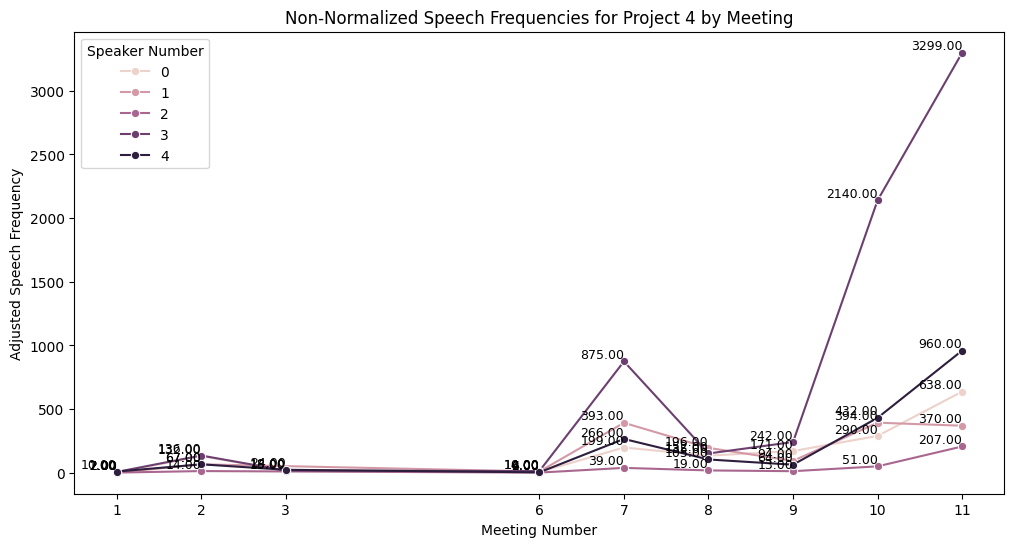

In [58]:


# Plot non-normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 4], x='meeting_number',
             y='adjusted_speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(
    set(speech_summary[speech_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(speech_summary[speech_summary['project'] == 4])):
    plt.text(speech_summary[speech_summary['project'] == 4]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 4]['adjusted_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 4]['adjusted_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Adjusted Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

## Plot Comparison of Normalized Total Speech Frequencies

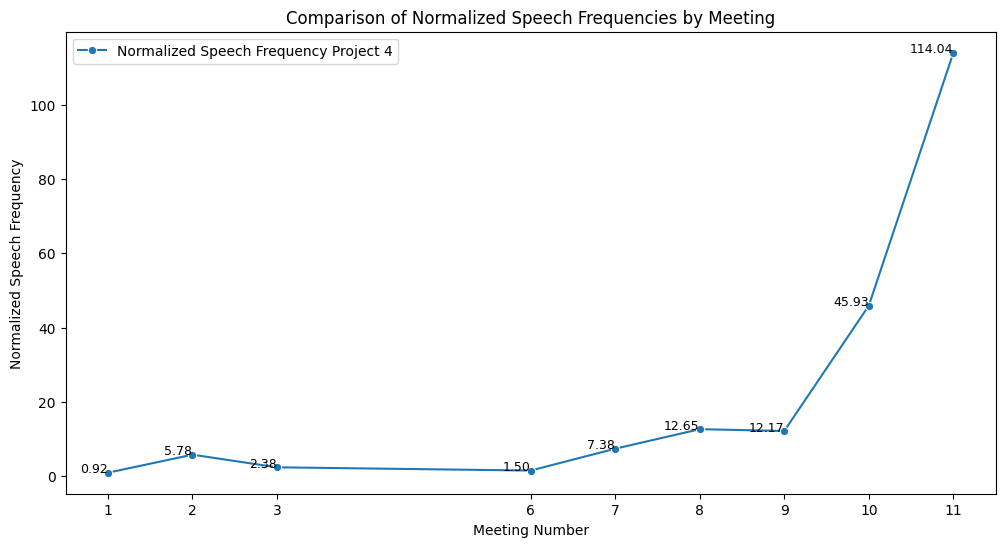

In [59]:
# Compare normalized speech frequencies by project
normalized_speech_comparison_df = speech_summary.groupby(
    ['project', 'meeting_number'])['normalized_speech_frequency'].sum().reset_index()
normalized_speech_comparison_df_pivot = normalized_speech_comparison_df.pivot(
    index='meeting_number', columns='project', values='normalized_speech_frequency')
normalized_speech_comparison_df_pivot.columns = [
    'Normalized_Speech_Frequency_Project4']
normalized_speech_comparison_df_pivot.reset_index(inplace=True)

# Filter meeting numbers to include only those with data points for either project
meeting_numbers_with_data = normalized_speech_comparison_df_pivot[(
    normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'] > 0)]['meeting_number']

plt.figure(figsize=(12, 6))
sns.lineplot(data=normalized_speech_comparison_df_pivot, x='meeting_number',
             y='Normalized_Speech_Frequency_Project4', label='Normalized Speech Frequency Project 4', marker='o')
for i in range(len(normalized_speech_comparison_df_pivot)):
    if normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(normalized_speech_comparison_df_pivot['meeting_number'].iloc[i], normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i],
                 f"{normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
plt.xticks(ticks=meeting_numbers_with_data)

plt.title('Comparison of Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend()
plt.show()

## Plot Comparison of Normalized Total Speech Frequencies by Each Speaker

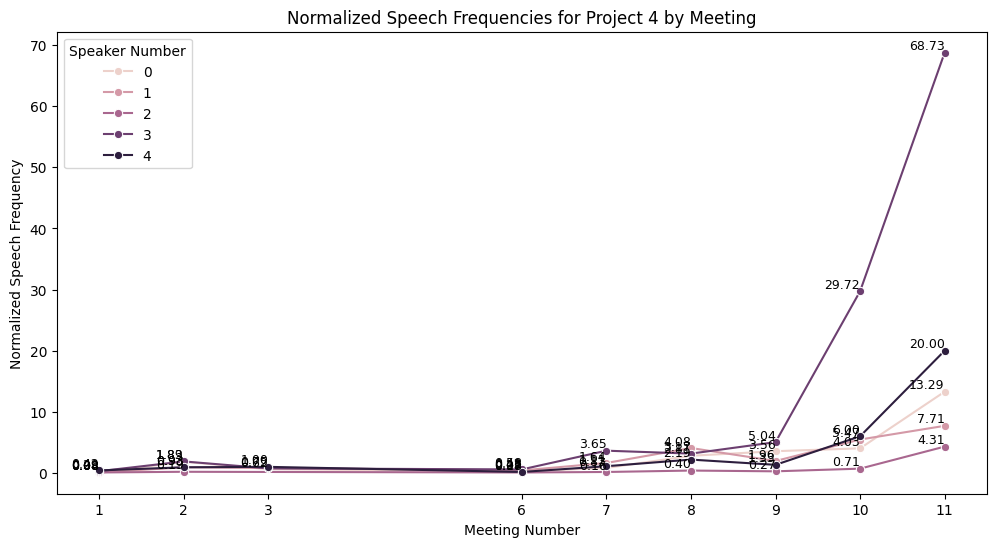

In [60]:


# Plot normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 4], x='meeting_number',
             y='normalized_speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(
    set(speech_summary[speech_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(speech_summary[speech_summary['project'] == 4])):
    plt.text(speech_summary[speech_summary['project'] == 4]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 4]['normalized_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 4]['normalized_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

## Plot Comparison of Non-Normalized Total Interactions

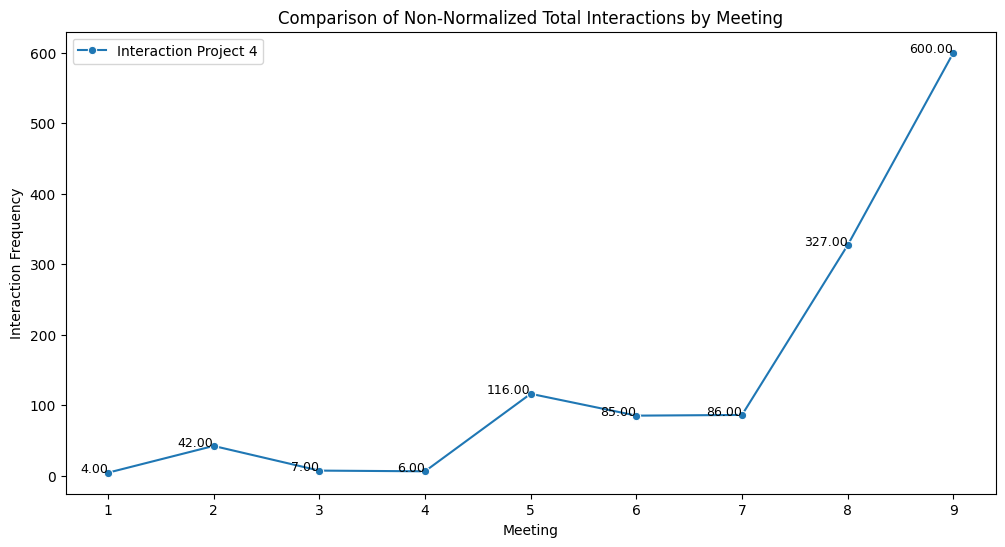

In [61]:
# Compute Interaction Frequencies Excluding Self-Interactions
interaction_frequencies_project4 = interaction_summary[interaction_summary['project'] == 4].groupby(
    'meeting_number')['count'].sum().reset_index()

# Compare interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1, len(interaction_frequencies_project4) + 1),
    'Interaction_Project4': interaction_frequencies_project4.set_index('meeting_number')['count']
}).reset_index(drop=True)

# Plot comparison of interaction frequencies
plt.figure(figsize=(12, 6))

sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project4',
             label='Interaction Project 4', marker='o')
for i in range(len(comparison_df)):

    if comparison_df['Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Interaction_Project4'].iloc[i],
                 f"{comparison_df['Interaction_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(
    comparison_df['Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Non-Normalized Total Interactions by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Interaction Frequency')
plt.legend()
plt.show()

## Plot Comparison of Non-Normalized Total Interactions by Each Speaker

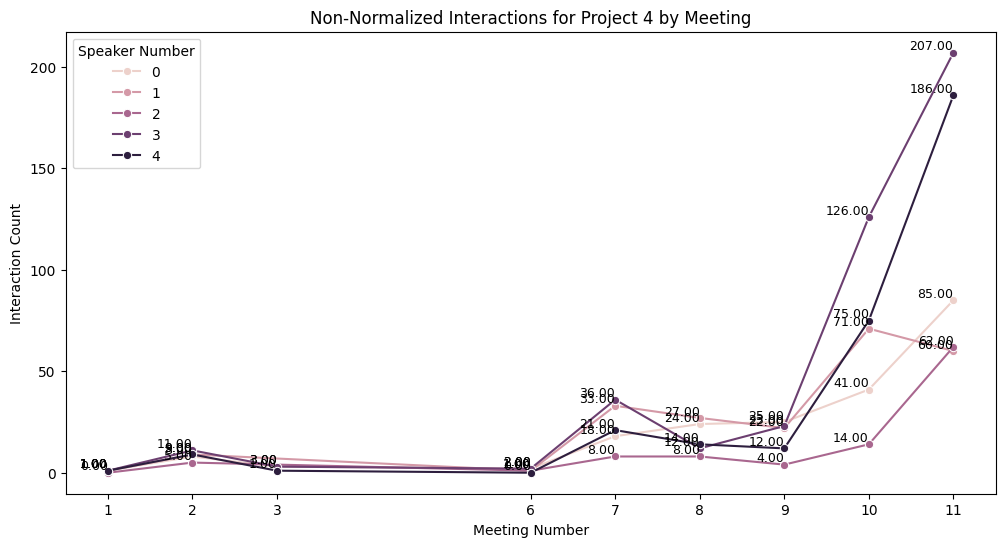

In [62]:


# Exclude self-interactions and summarize interactions for Project 4
summary_project_4 = interaction_summary[interaction_summary['project'] == 4].groupby(
    ['meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Plot non-normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_4, x='meeting_number',
             y='count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(summary_project_4['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(summary_project_4)):
    plt.text(summary_project_4['meeting_number'].iloc[i], summary_project_4['count'].iloc[i],
             f"{summary_project_4['count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

## Plot Comparison of Normalized Total Interactions

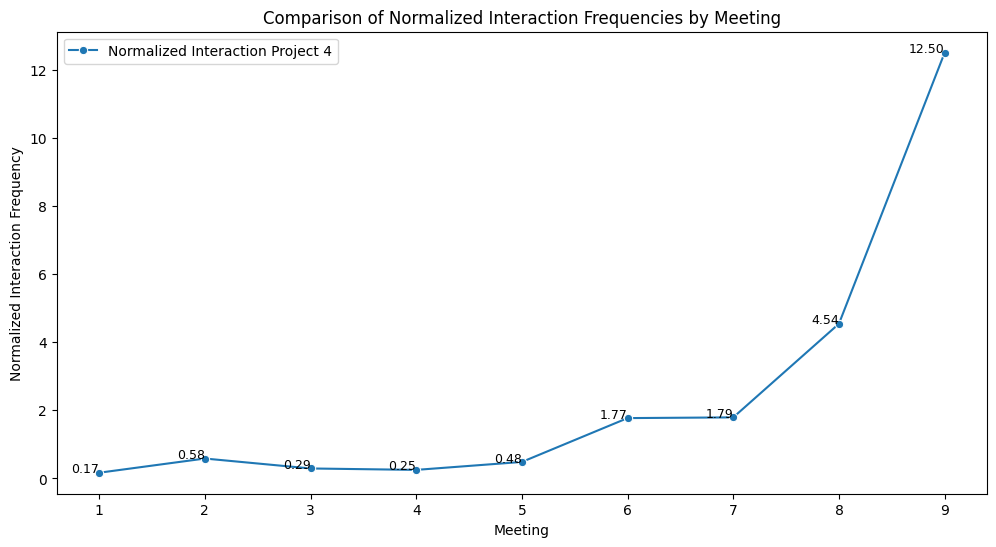

In [63]:
# Compute Interaction Frequencies Excluding Self-Interactions for each project

interaction_frequencies_project4 = interaction_summary[interaction_summary['project'] == 4].groupby(
    ['meeting_number'])['normalized_interaction_count'].sum().reset_index()

# Compare normalized interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1,  len(interaction_frequencies_project4) + 1),
    'Normalized_Interaction_Project4': interaction_frequencies_project4.set_index('meeting_number')['normalized_interaction_count']
}).reset_index(drop=True)

# Plot comparison of normalized interaction frequencies
plt.figure(figsize=(12, 6))

sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project4',
             label='Normalized Interaction Project 4', marker='o')
for i in range(len(comparison_df)):
    if comparison_df['Normalized_Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Normalized_Interaction_Project4'].iloc[i],
                 f"{comparison_df['Normalized_Interaction_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(
    comparison_df['Normalized_Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Normalized Interaction Frequencies by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Normalized Interaction Frequency')
plt.legend()
plt.show()

## Plot Comparison of Normalized Total Interactions by Each Speaker

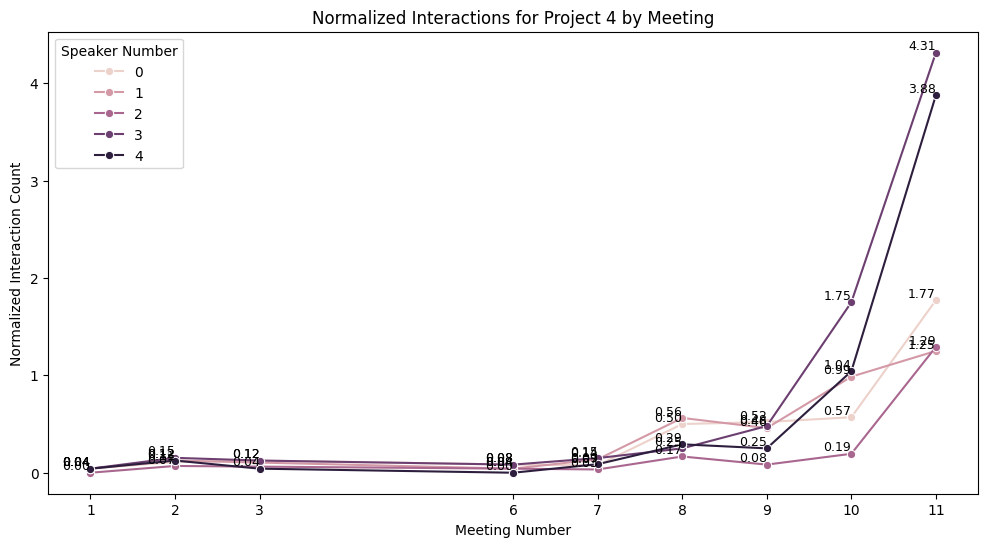

In [64]:


# Plot normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=interaction_summary[interaction_summary['project'] == 4],
             x='meeting_number', y='normalized_interaction_count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(
    set(interaction_summary[interaction_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(interaction_summary[interaction_summary['project'] == 4])):
    plt.text(interaction_summary[interaction_summary['project'] == 4]['meeting_number'].iloc[i], interaction_summary[interaction_summary['project'] == 4]['normalized_interaction_count'].iloc[i],
             f"{interaction_summary[interaction_summary['project'] == 4]['normalized_interaction_count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

## Plot Comparison of Network Densities

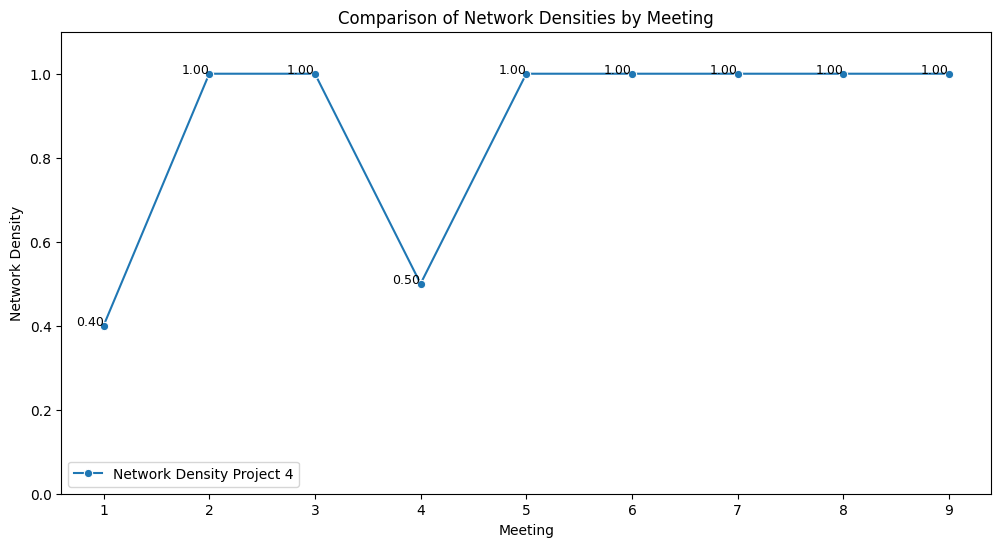

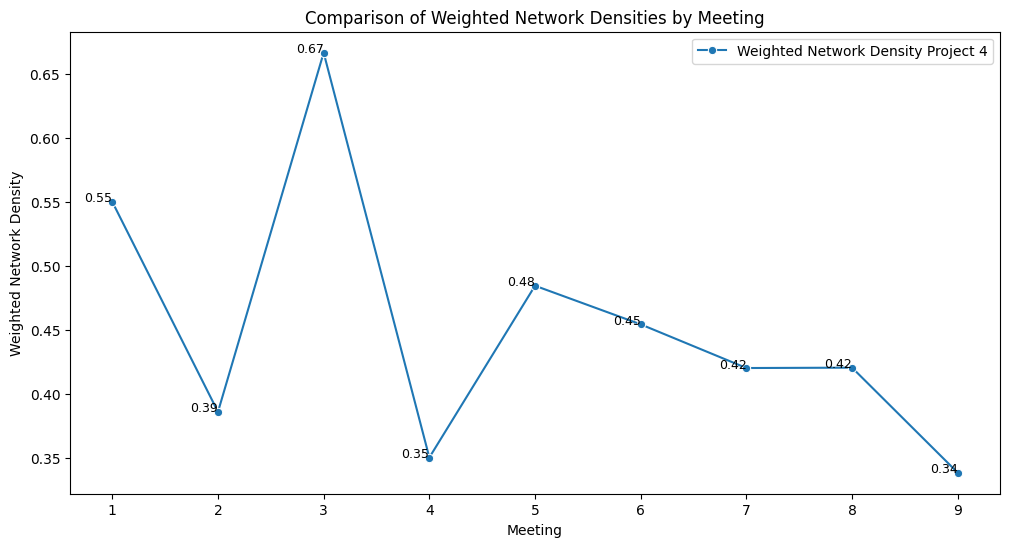

In [65]:
# Extract unique network densities and weighted network densities for each project

densities_project4 = dataset[dataset['project'] == 4].groupby(
    'meeting_number')['network_density'].unique().apply(lambda x: x[0])

weighted_densities_project4 = dataset[dataset['project'] == 4].groupby(
    'meeting_number')['weighted_network_density'].unique().apply(lambda x: x[0])

# Plot comparison of network densities
plt.figure(figsize=(12, 6))

df_project4 = pd.DataFrame({'Meeting': range(
    1, len(densities_project4) + 1), 'Network Density': densities_project4})

sns.lineplot(data=df_project4, x='Meeting', y='Network Density',
             label='Network Density Project 4', marker='o')

for i in range(len(df_project4)):
    if df_project4['Network Density'].iloc[i] > 0:
        plt.text(df_project4['Meeting'].iloc[i], df_project4['Network Density'].iloc[i],
                 f"{df_project4['Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')

plt.ylim(0, 1.1)
plt.xticks(ticks=range(1, (len(df_project4)) + 1))
plt.title('Comparison of Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Network Density')
plt.legend()
plt.show()

# Plot comparison of weighted network densities
plt.figure(figsize=(12, 6))

df_weighted_project4 = pd.DataFrame({'Meeting': range(1, len(
    weighted_densities_project4) + 1), 'Weighted Network Density': weighted_densities_project4})

sns.lineplot(data=df_weighted_project4, x='Meeting', y='Weighted Network Density',
             label='Weighted Network Density Project 4', marker='o')

for i in range(len(df_weighted_project4)):
    if df_weighted_project4['Weighted Network Density'].iloc[i] > 0:
        plt.text(df_weighted_project4['Meeting'].iloc[i], df_weighted_project4['Weighted Network Density'].iloc[i],
                 f"{df_weighted_project4['Weighted Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')

plt.xticks(ticks=range(
    1, (len(df_weighted_project4)) + 1))
plt.title('Comparison of Weighted Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Weighted Network Density')
plt.legend()
plt.show()

## Plot Comparison of Centralities

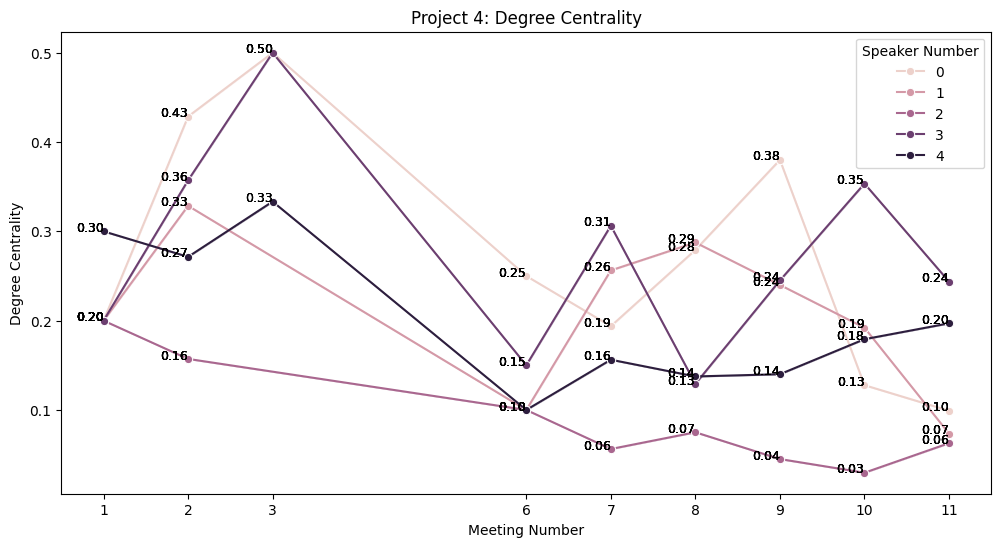

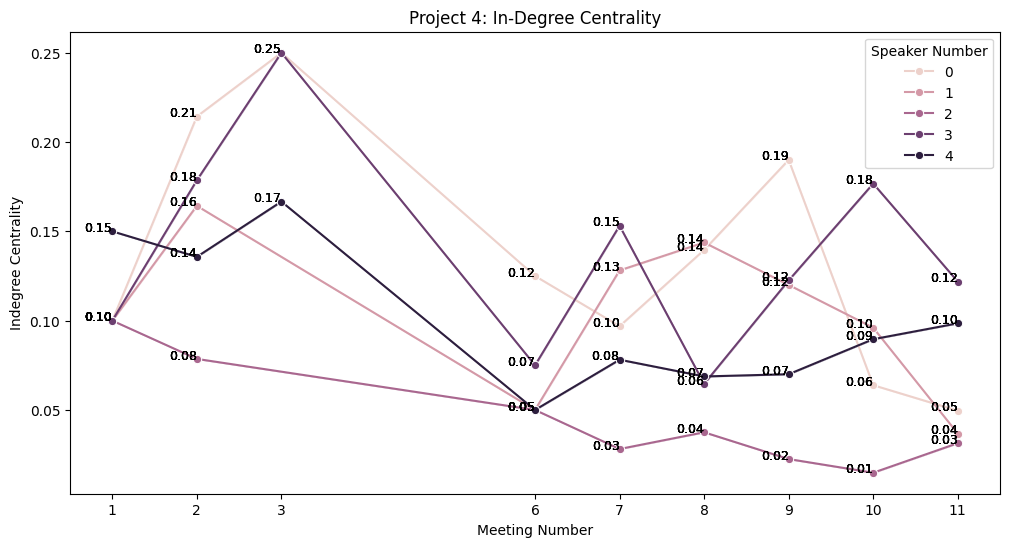

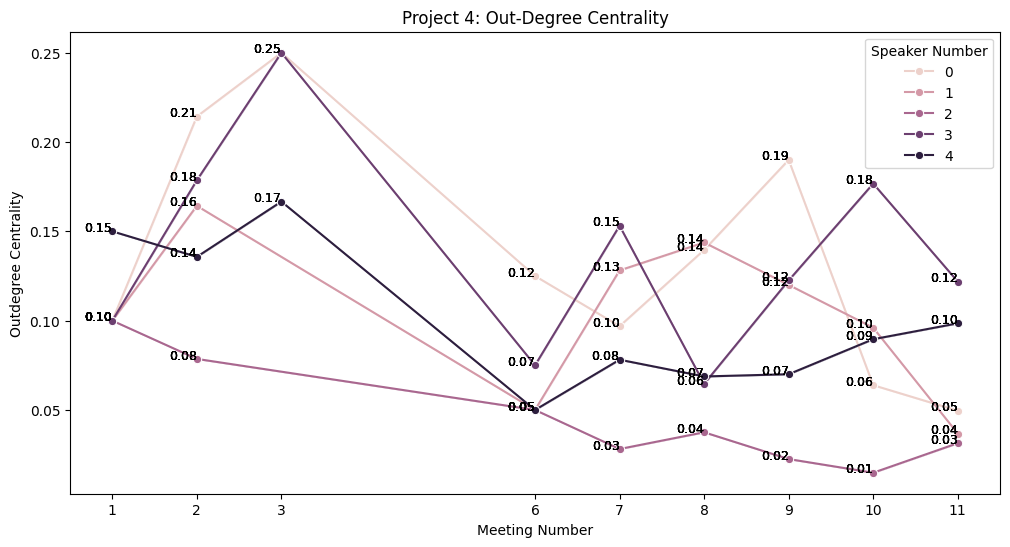

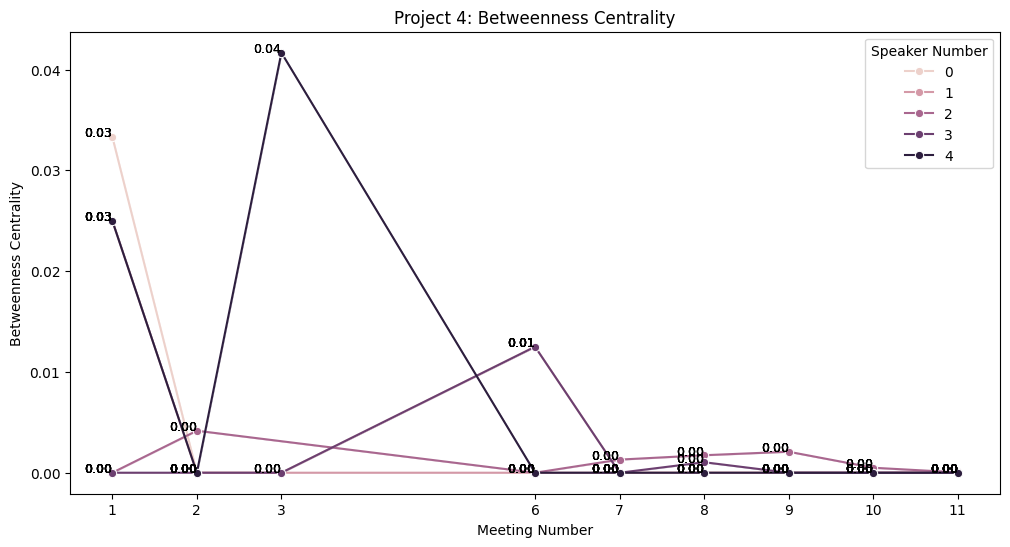

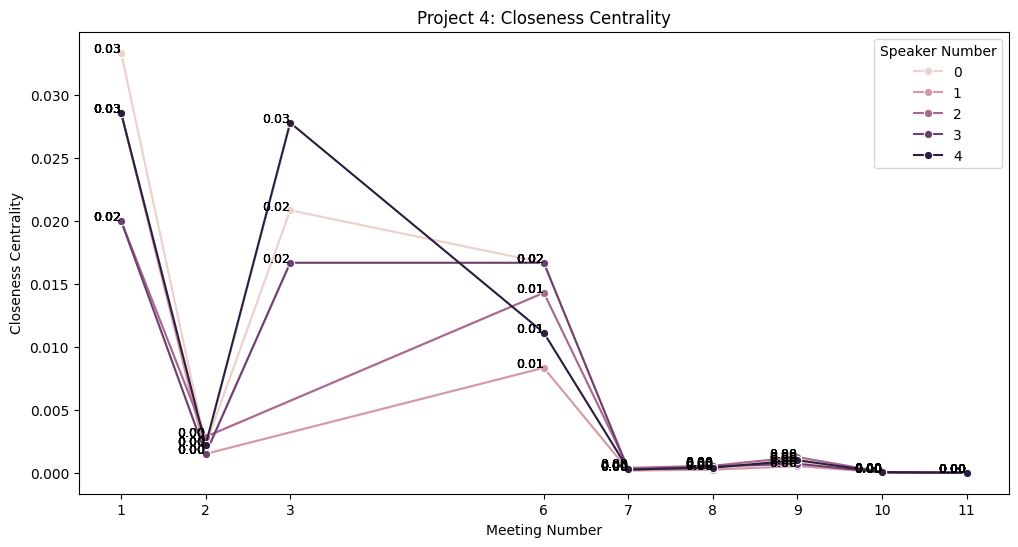

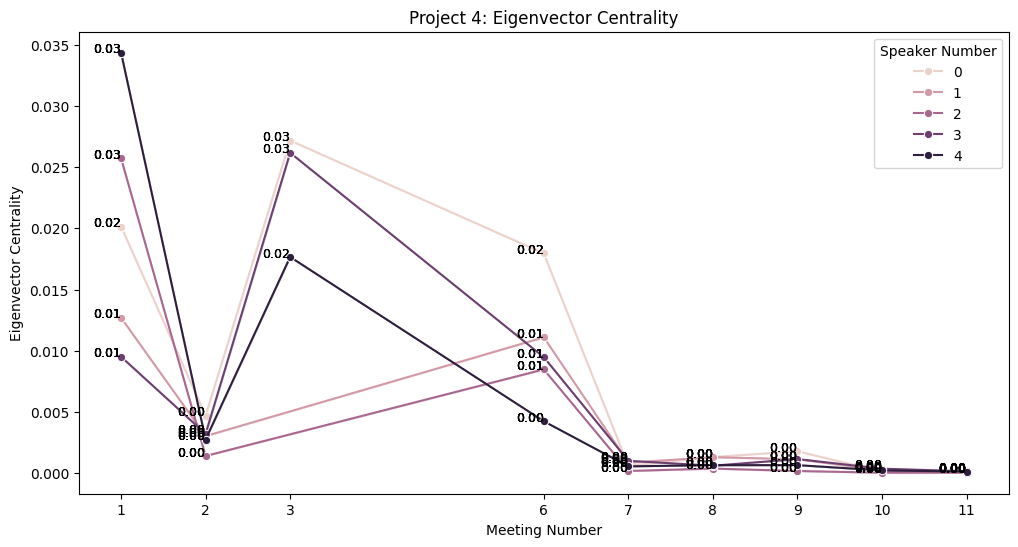

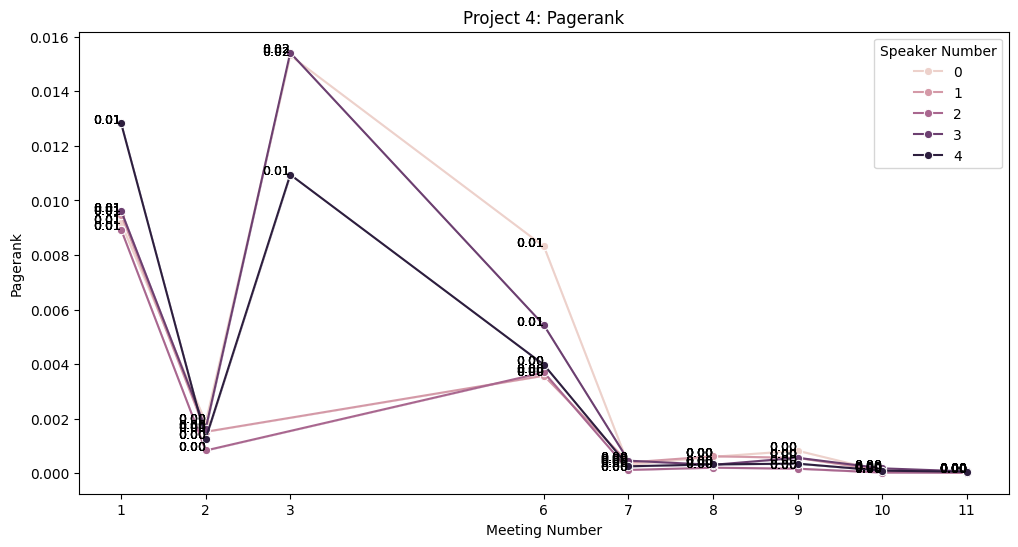

In [66]:
# Define function to plot centrality measures by speaker
def plot_centrality_measures_by_speaker(dataset, measure, title):

    plt.figure(figsize=(12, 6))
    project_4_data = dataset[dataset['project'] == 4]
    sns.lineplot(data=project_4_data, x='meeting_number', y=measure,
                 hue='speaker_number', marker='o', legend='full')
    for speaker in project_4_data['speaker_number'].unique():
        speaker_data = project_4_data[project_4_data['speaker_number'] == speaker]
        for i in range(len(speaker_data)):
            plt.text(speaker_data['meeting_number'].iloc[i], speaker_data[measure].iloc[i],
                     f"{speaker_data[measure].iloc[i]:.2f}", fontsize=9, ha='right')
    plt.xticks(ticks=project_4_data['meeting_number'].unique())
    plt.title(f'Project 4: {title}')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend(title='Speaker Number')
    plt.show()


# Plot comparison of centralities by speaker
centrality_measures = [
    'degree_centrality', 'indegree_centrality', 'outdegree_centrality', 'betweenness_centrality', 'closeness_centrality',
    'eigenvector_centrality', 'pagerank'
]
titles = [
    'Degree Centrality', 'In-Degree Centrality', 'Out-Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality',
    'Eigenvector Centrality', 'Pagerank',
]

for measure, title in zip(centrality_measures, titles):
    plot_centrality_measures_by_speaker(dataset, measure, title)

## Plot Interaction Network Graph

In [67]:
dataset

,id,project,meeting_number,speaker_number,speech_frequency,total_words,duration,normalized_speech_frequency,speaker_id,next_speaker_id,...,weighted_network_density,gini_coefficient,interaction_equality_index,degree_centrality,indegree_centrality,outdegree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,4_1_SPEAKER_00,4,1,0,1,22,24,0.041667,0,0,...,0.550000,0.200000,0.500000,0.20000,0.100000,0.100000,0.033333,0.033333,0.02015,0.009161
1,4_1_SPEAKER_00,4,1,0,1,22,24,0.041667,0,1,...,0.550000,0.200000,0.500000,0.20000,0.100000,0.100000,0.033333,0.033333,0.02015,0.009161
2,4_1_SPEAKER_00,4,1,0,1,22,24,0.041667,0,2,...,0.550000,0.200000,0.500000,0.20000,0.100000,0.100000,0.033333,0.033333,0.02015,0.009161
3,4_1_SPEAKER_00,4,1,0,1,22,24,0.041667,0,3,...,0.550000,0.200000,0.500000,0.20000,0.100000,0.100000,0.033333,0.033333,0.02015,0.009161
4,4_1_SPEAKER_00,4,1,0,1,22,24,0.041667,0,4,...,0.550000,0.200000,0.500000,0.20000,0.100000,0.100000,0.033333,0.033333,0.02015,0.009161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,4_11_SPEAKER_04,4,11,4,960,5474,48,20.000000,4,0,...,0.338095,0.278667,0.471454,0.19697,0.098485,0.098485,0.000000,0.000004,0.00013,0.000060
205,4_11_SPEAKER_04,4,11,4,960,5474,48,20.000000,4,1,...,0.338095,0.278667,0.471454,0.19697,0.098485,0.098485,0.000000,0.000004,0.00013,0.000060
206,4_11_SPEAKER_04,4,11,4,960,5474,48,20.000000,4,2,...,0.338095,0.278667,0.471454,0.19697,0.098485,0.098485,0.000000,0.000004,0.00013,0.000060
207,4_11_SPEAKER_04,4,11,4,960,5474,48,20.000000,4,3,...,0.338095,0.278667,0.471454,0.19697,0.098485,0.098485,0.000000,0.000004,0.00013,0.000060


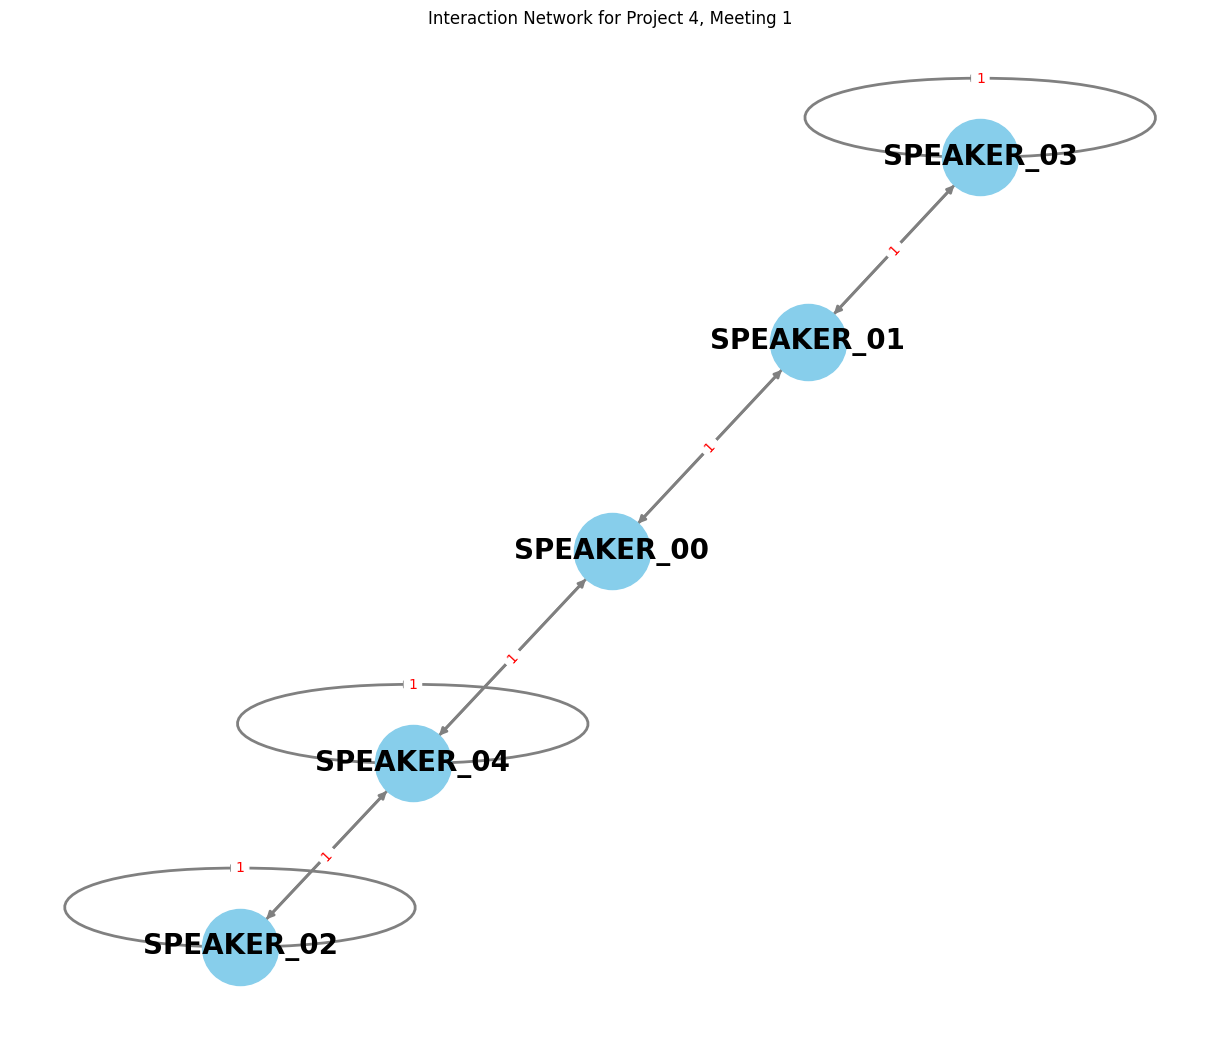

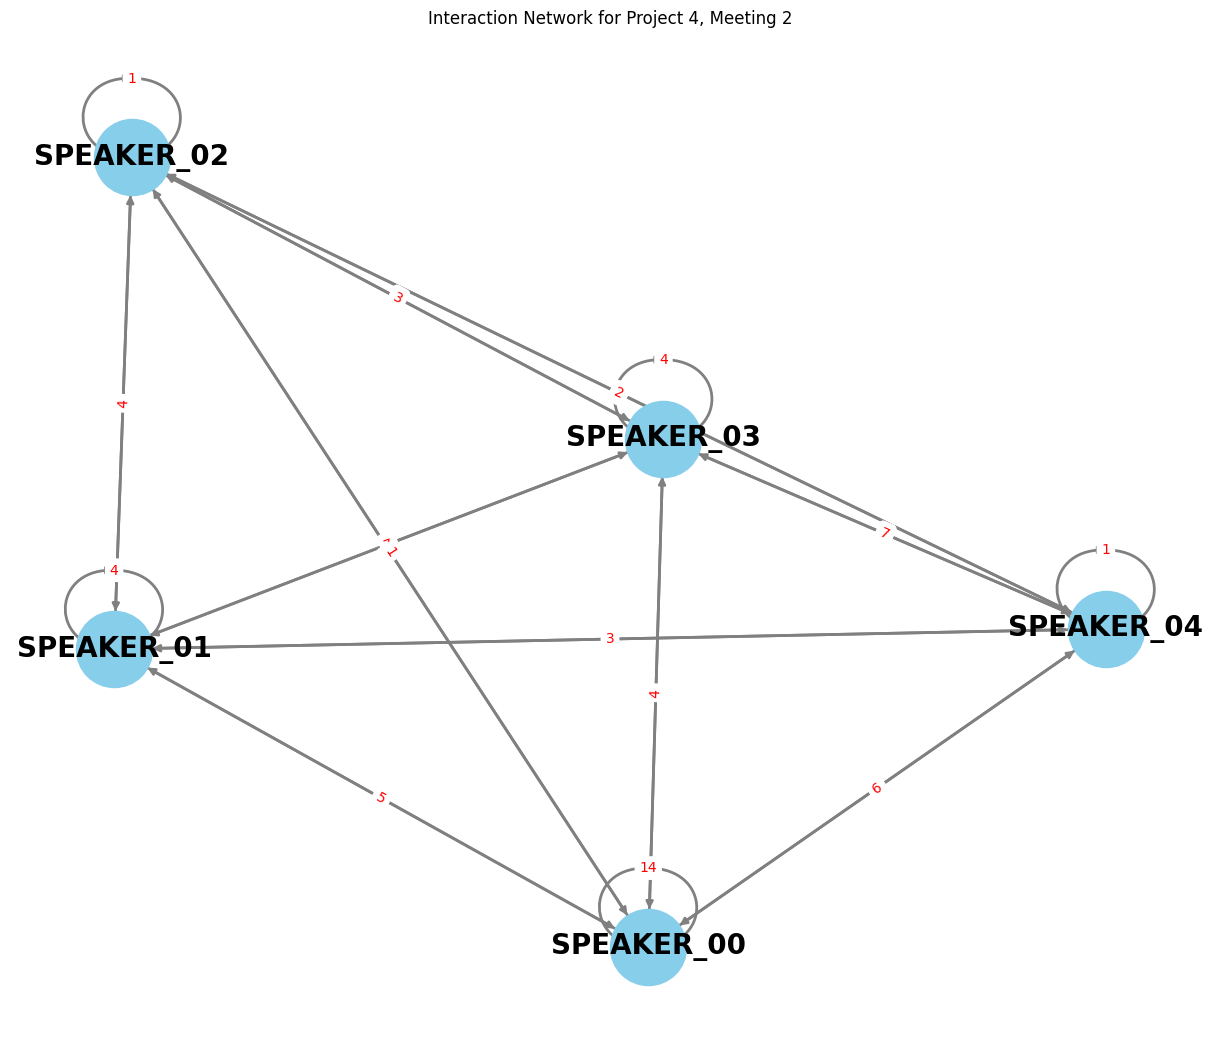

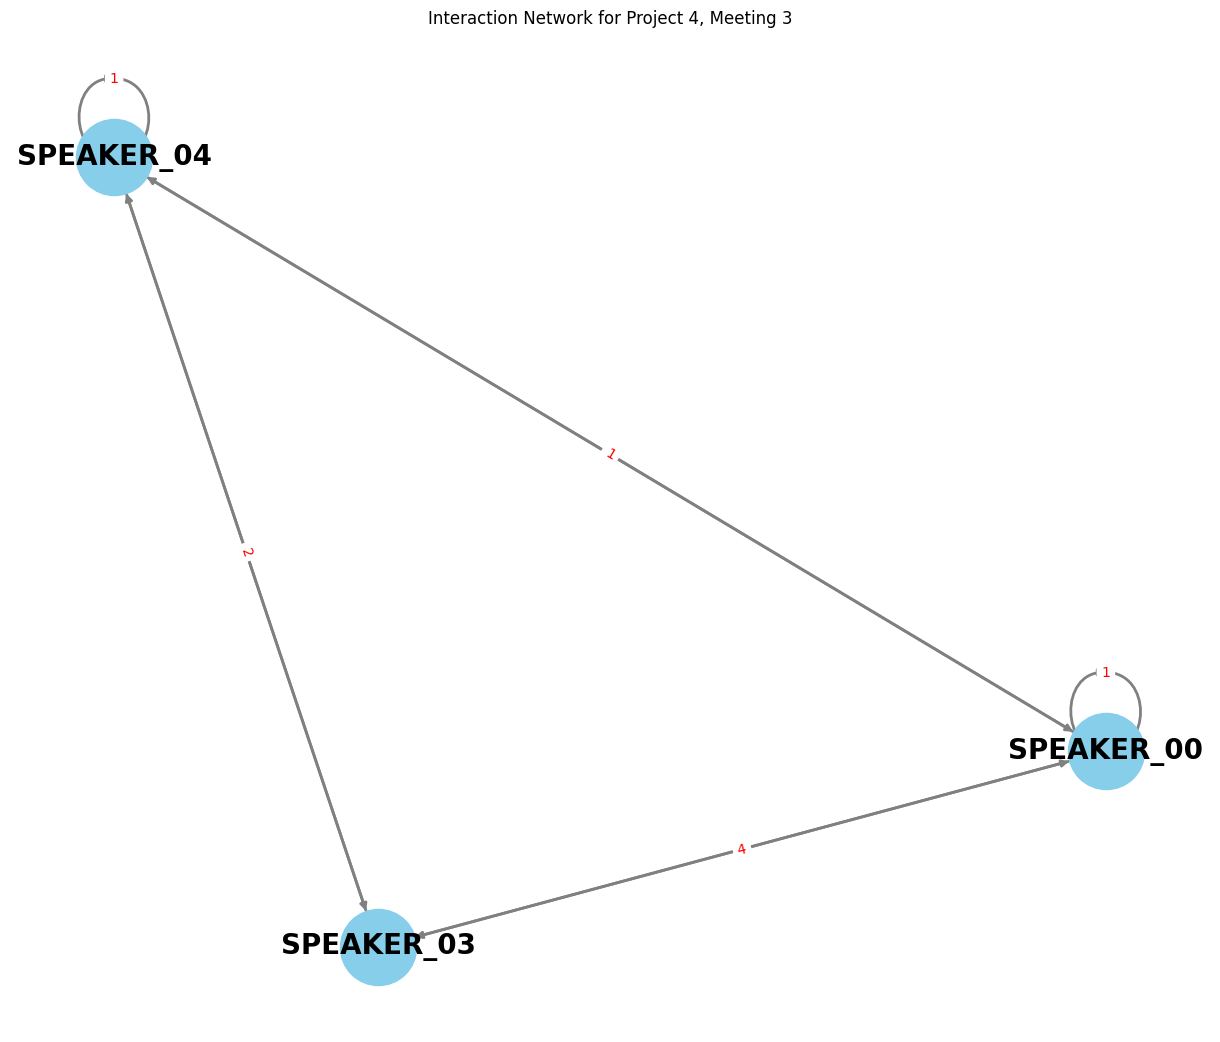

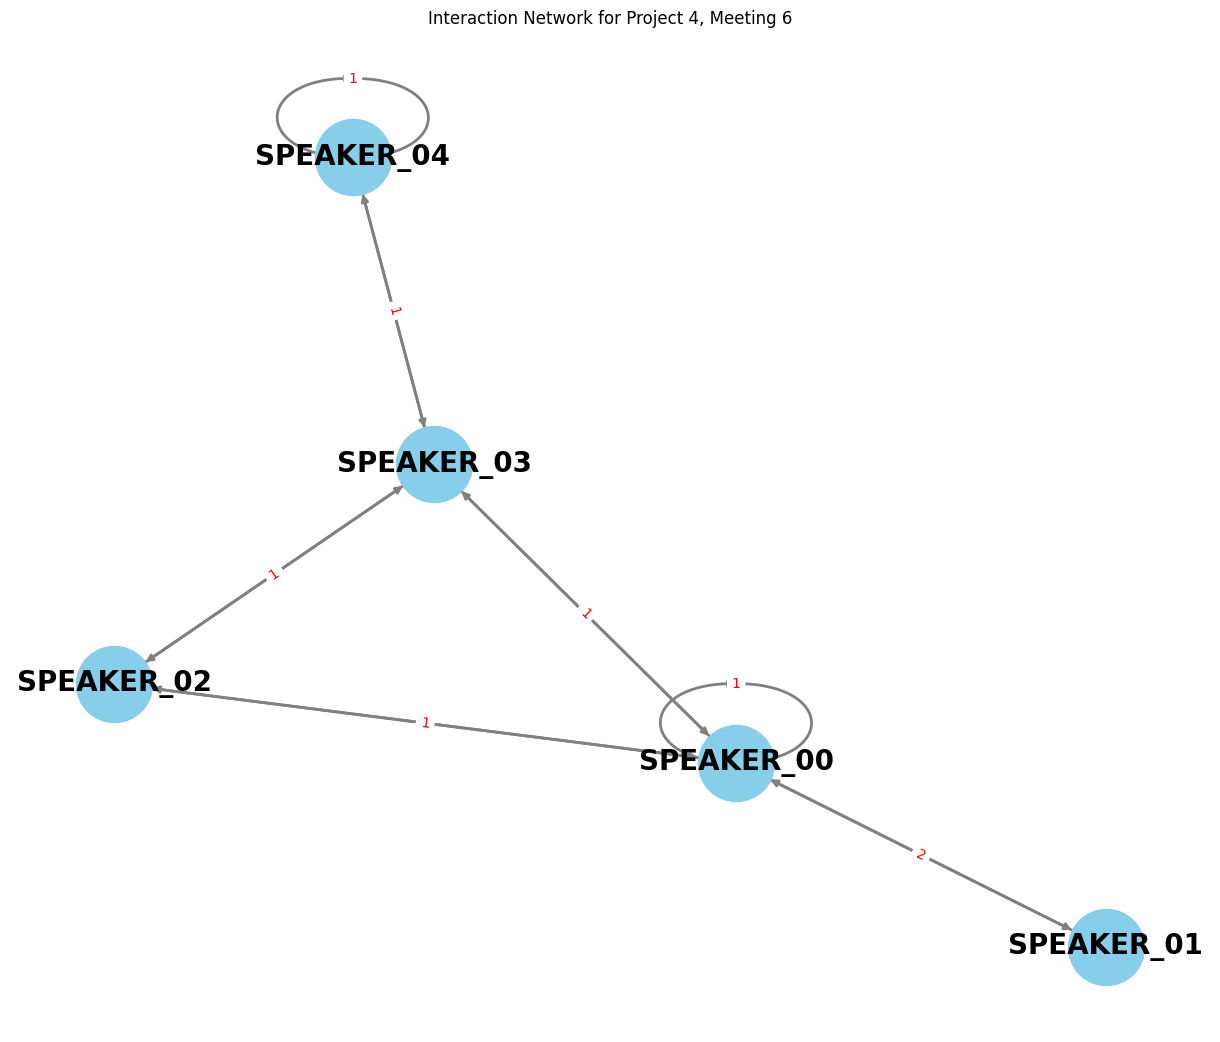

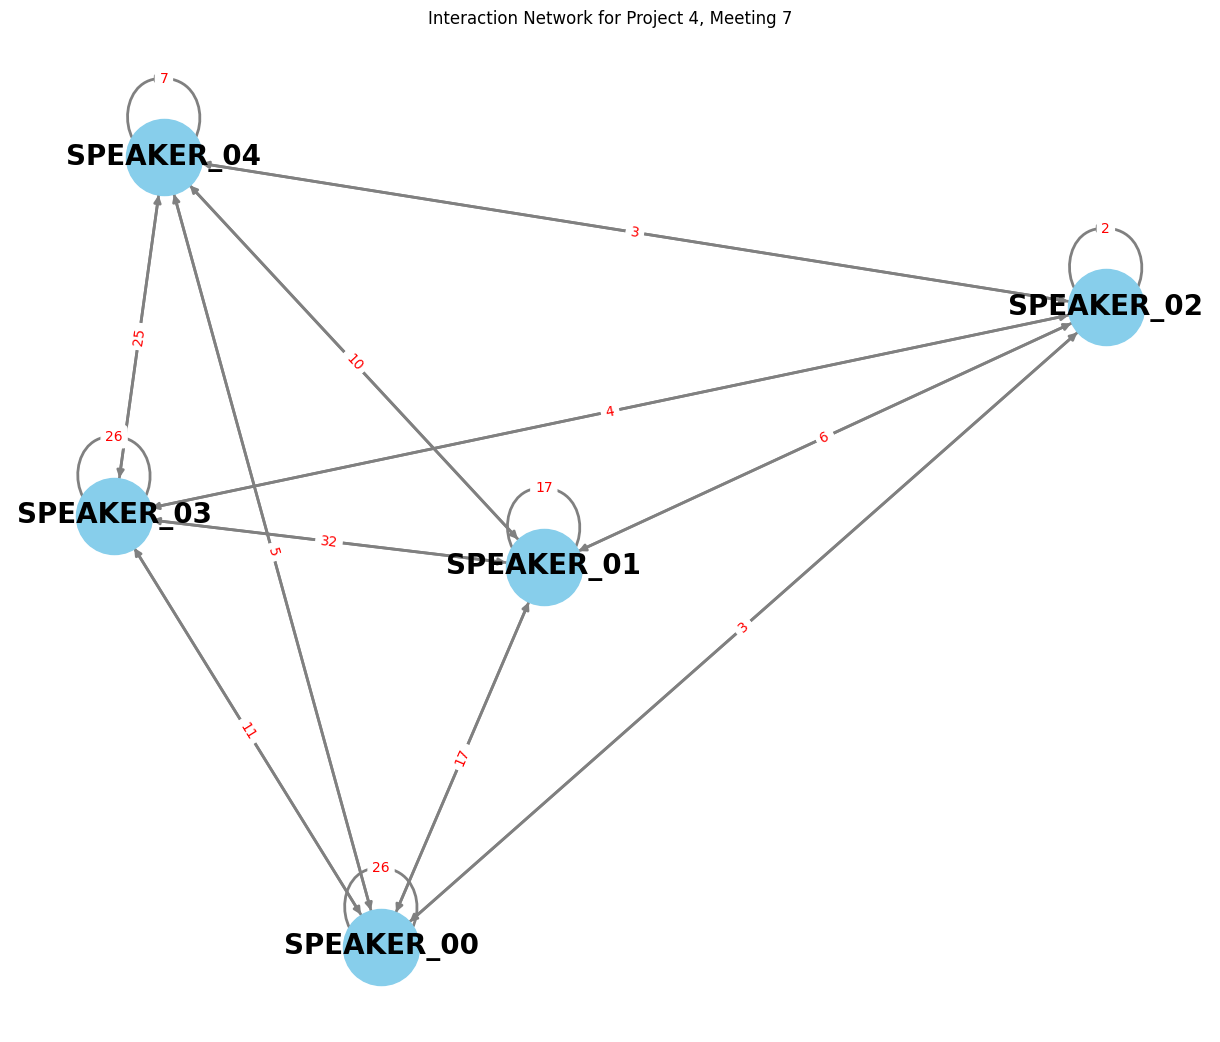

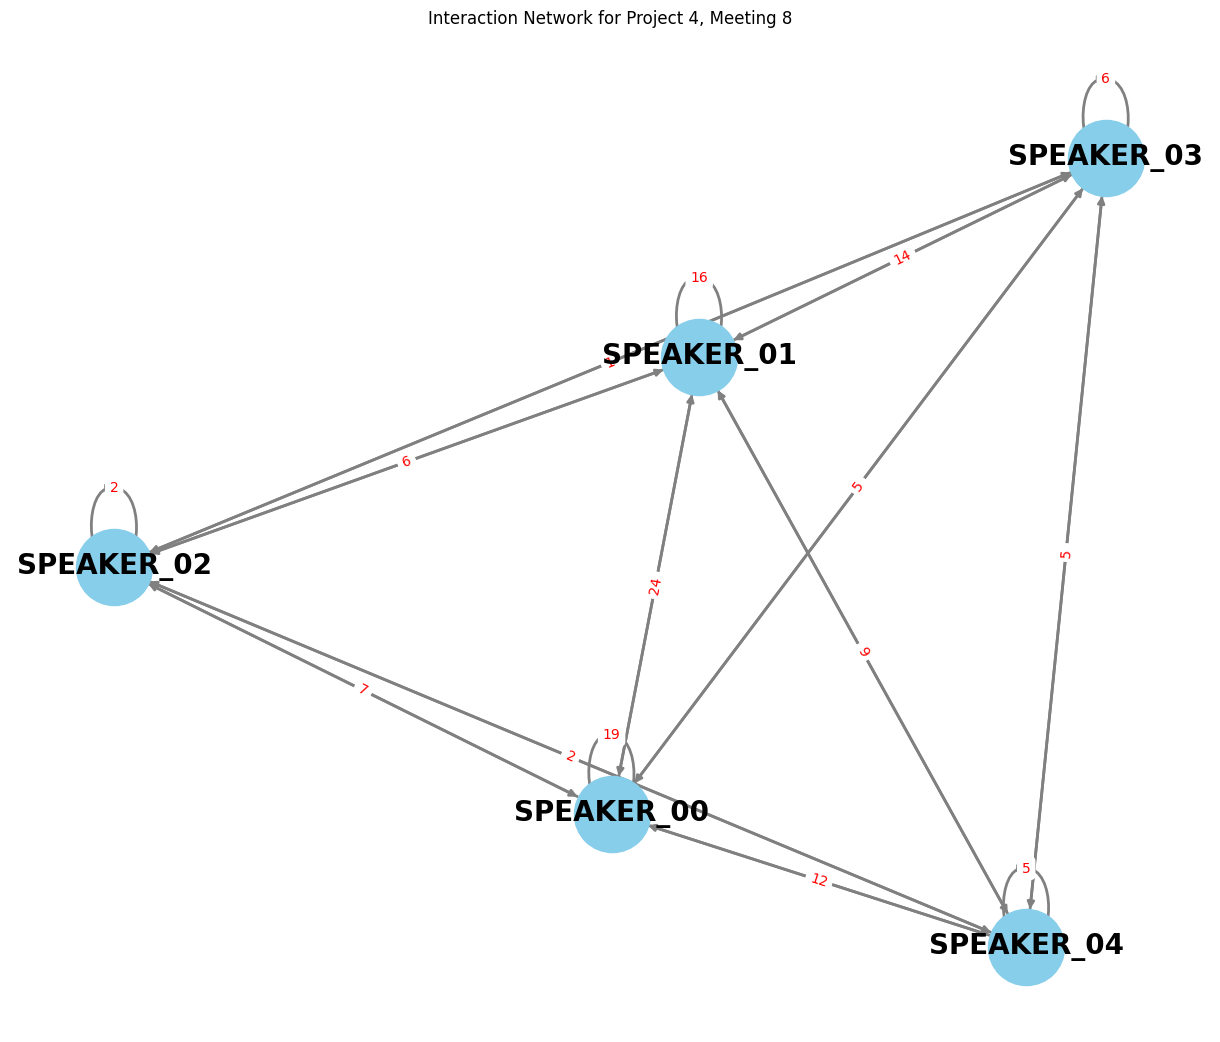

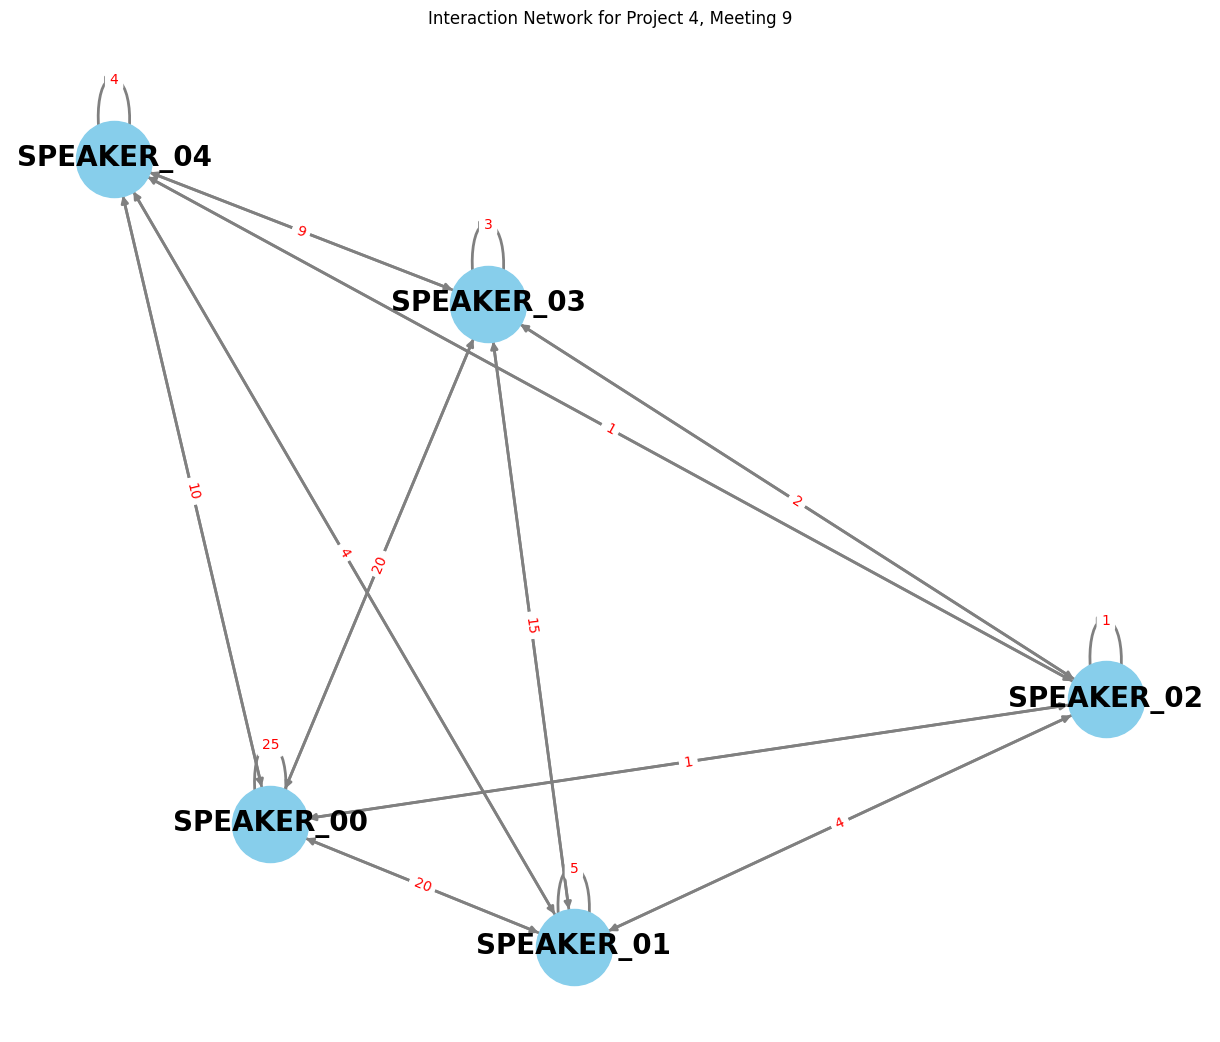

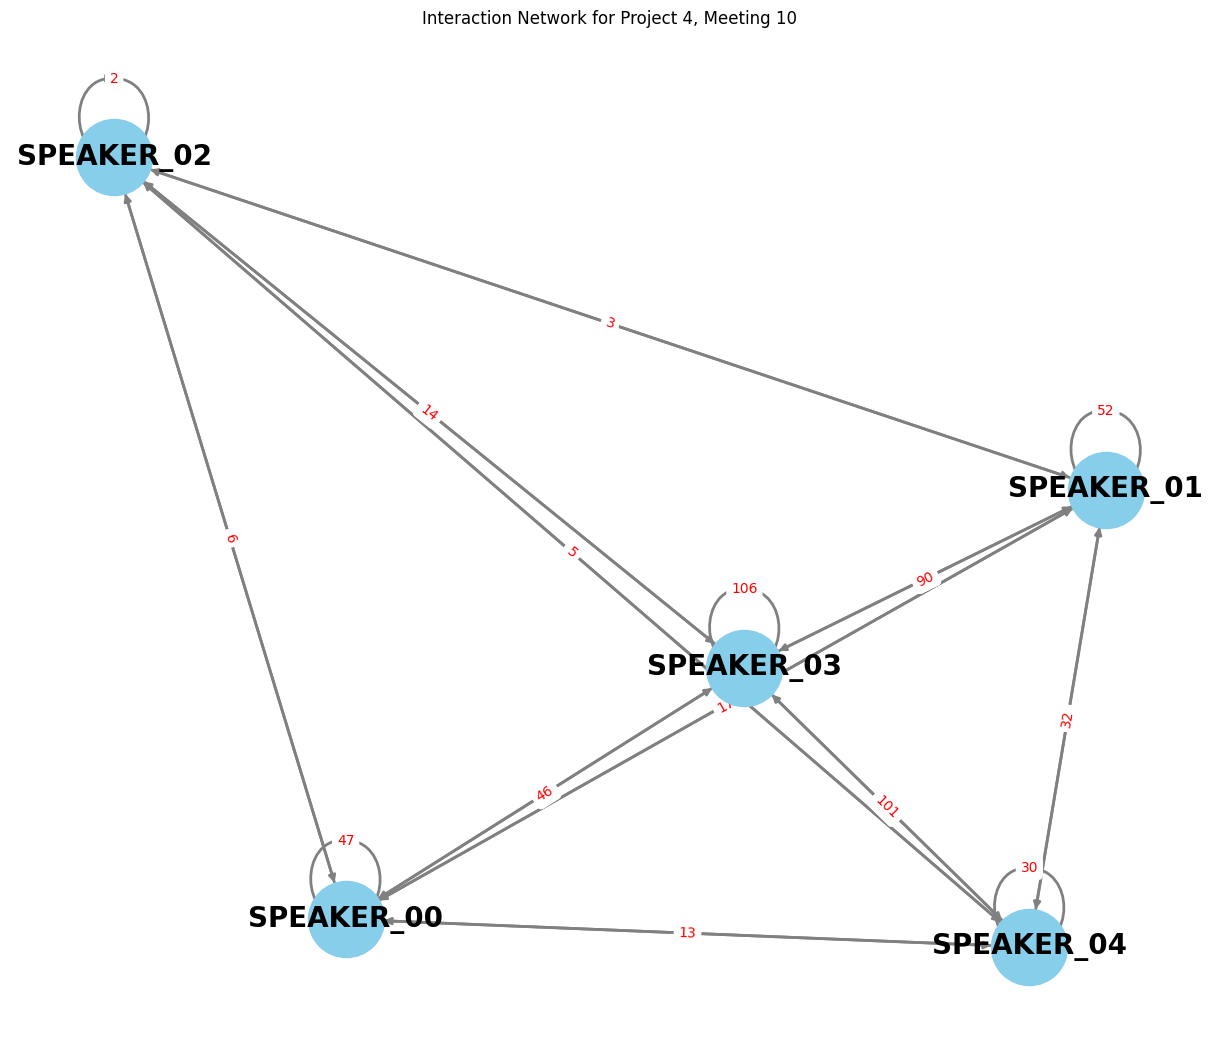

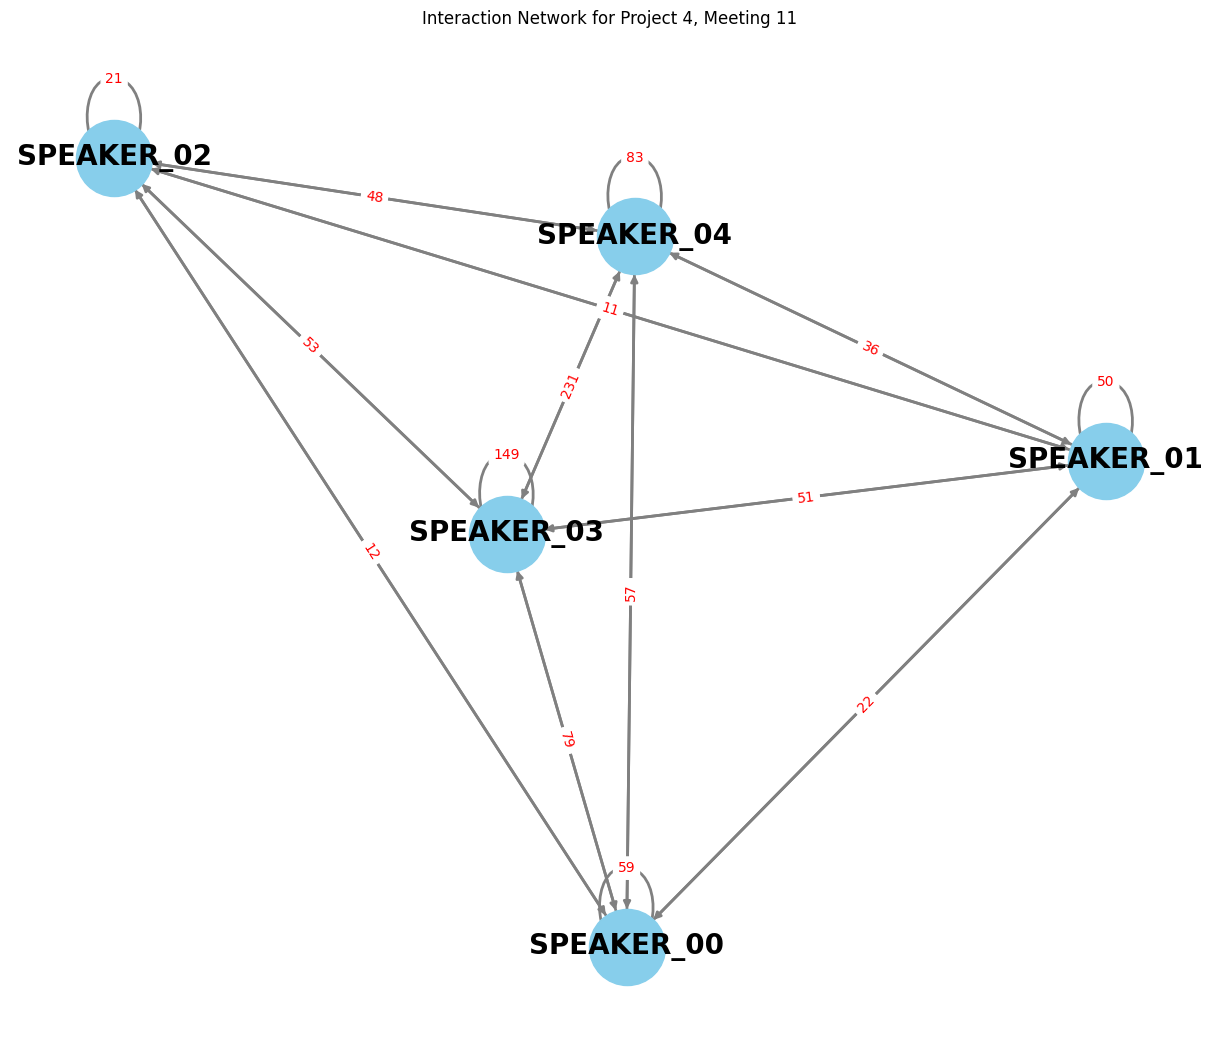

In [68]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


def create_interaction_graphs(df):
    graphs = []
    for meeting_number in df['meeting_number'].unique():
        G = nx.DiGraph()
        meeting_data = df[df['meeting_number'] == meeting_number]
        for i in range(len(meeting_data)):
            prev_speaker = f"SPEAKER_{meeting_data.iloc[i]['speaker_number']:02d}"
            next_speaker = f"SPEAKER_{meeting_data.iloc[i]['next_speaker_id']:02d}"
            count = meeting_data.iloc[i]['count']
            if count > 0:
                if G.has_edge(prev_speaker, next_speaker):
                    G[prev_speaker][next_speaker]['weight'] += count
                else:
                    G.add_edge(prev_speaker, next_speaker, weight=count)

                if G.has_edge(next_speaker, prev_speaker) and prev_speaker != next_speaker:
                    G[next_speaker][prev_speaker]['weight'] += count
                else:
                    G.add_edge(next_speaker, prev_speaker, weight=count)

        graphs.append(G)
    return graphs


graphs_project4 = create_interaction_graphs(dataset[dataset['project'] == 4])


def plot_interaction_network(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue",
            font_size=20, font_color="black", font_weight="bold", width=2, edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()


for i, G in enumerate(graphs_project4):
    if (i > 2):
        i = i+2
    plot_interaction_network(
        G, f'Interaction Network for Project 4, Meeting {i+1}')